# Importing Libraries

In [2]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import requests
from io import BytesIO
import base64
from Binance_API import BinanceAPI
from RiskMetrics import RiskAnalysis, rolling_var,kupiec_test, performance,variance_decomposition_ex_post
from PnL_Computation import PnL
from Stock_Data import get_close
from Rebalancing import *
from Git import *

In [3]:
git=GitHub(token,repo_owner,repo_name,branch)
Binance=BinanceAPI(binance_api_key,binance_api_secret)
Pnl_calculation=PnL(binance_api_key,binance_api_secret)

# Loading Benchmark

In [5]:
start_date=datetime.datetime(2020,1,1)
today=datetime.datetime.today()
days=(today-start_date).days
remaining=days%500
numbers_of_table=days//500
tickers=Binance.get_market_cap()['Ticker'].iloc[:40].to_list()
temp_end=start_date
scope_prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    scope_prices=scope_prices.combine_first(data)
    
temp_end=(today-datetime.timedelta(remaining))
data=Binance.get_price(tickers,temp_end)
scope_prices=scope_prices.combine_first(data)
scope_prices=scope_prices.sort_index()
scope_prices = scope_prices[~scope_prices.index.duplicated(keep='first')]
scope_prices.index=pd.to_datetime(scope_prices.index)
tickers2=Binance.get_market_cap()['Ticker'].iloc[:20].to_list()
prices=scope_prices[tickers2]
returns=np.log(1+prices.pct_change(fill_method=None))
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na].sort_index()
dataframe=prices[with_no_na].sort_index()
dataframe.index=pd.to_datetime(dataframe.index)
returns_to_use.index=pd.to_datetime(returns_to_use.index)
returns_to_use = returns_to_use[~returns_to_use.index.duplicated(keep='first')]

month=list(sorted(set(returns_to_use.index + pd.offsets.BMonthEnd(0))))
#month_end=pd.to_datetime(mrat_wo_na.index)
month = pd.to_datetime(month)

idx1 = pd.Index(returns_to_use.iloc[:-1].index)
idx2 = pd.Index(month)
closest_dates = idx1[idx1.get_indexer(idx2, method='nearest')]

dates_end=list(closest_dates)
dates_end.insert(0,returns_to_use.index[1])
dates_end.append(returns_to_use.index[-1])
dates_end=sorted(list(set(dates_end)))
dates_end.pop(0)
dates_end=sorted(list(set(dates_end)))

results={}

if 'USDCUSDT' in returns_to_use.columns:
    
    cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

else:

    cash=[]
# gold_positions=np.where(returns_to_use.columns=='GOLD.PA')[0][0]
#om_limit=np.where(returns_to_use.columns=='OMUSDT')[0][0]

for i in range(len(dates_end)-1):
    
    try:
        dataset=returns_to_use.loc[dates_end[i]:dates_end[i+1]]        
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        
        optimal=risk.optimize(objective='minimum_variance',constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash]-0.00}#,
                                                                       ])# {'type': 'eq', 'fun': lambda weights: weights[gold_positions]-0.00}])
        
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
        pass

rolling_optimization=pd.DataFrame(results,index=dataframe.columns).T
rolling_optimization.loc[dates_end[0]]=1/len(dataframe.columns)
rolling_optimization=rolling_optimization.sort_index()

performance_model=pd.DataFrame()

In [6]:
q=rebalanced_dynamic_quantities(dataframe,rolling_optimization.iloc[:-2])
results=q*dataframe

performance_model['Fund']=results.sum(axis=1)
performance_model['Bitcoin']=dataframe['BTCUSDT']
#performance['Mantra']=dataframe['OMUSDT']

performance_model_pct=performance_model.copy()
performance_model_pct=performance_model_pct.pct_change(fill_method=None)

# Importing Data

In [8]:
Binance=BinanceAPI(binance_api_key,binance_api_secret)
Pnl_calculation=PnL(binance_api_key,binance_api_secret)

In [9]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [11]:
start_date=datetime.datetime(2023,12,1)
enddate=datetime.datetime.today()

In [12]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [13]:
quantities_api=Binance.binance_api.user_asset()

current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [14]:
# trade_history=pd.read_excel('Trades USDT.xlsx')
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Trade%20History%20Reconstructed.xlsx'
myfile = requests.get(url)
trade_history=pd.read_excel(BytesIO(myfile.content))

In [15]:
price=Pnl_calculation.get_trade_in_usdt(trade_history)

TRXUSDT 0
BTCUSDT 1
TRXUSDT 2
BNBUSDT 3
ETHUSDT 4
SOLUSDT 5
BNBUSDT 6
USDTTRY 7
JASMYUSDT 8
BNBUSDT 9
BBUSDT 10
USDTTRY 11
BNBUSDT 12
USDTTRY 13
TRXUSDT 14
USDTTRY 15
JASMYUSDT 16
BNBUSDT 17
BBUSDT 18
OMUSDT 19
OMUSDT 20
OMUSDT 21
TRXUSDT 22
BTCUSDT 23
OMUSDT 24
BTCUSDT 25
TRXUSDT 26
TRXUSDT 27
BBUSDT 28
BNBUSDT 29
TRXUSDT 30
BTCUSDT 31
TRXUSDT 32
BTCUSDT 33
MKRUSDT 34
BTCUSDT 35
MKRUSDT 36
EURUSDT 37
EURUSDT 38
BBUSDT 39
BNBUSDT 40
JASMYUSDT 41
PEPEUSDT 42
NOTUSDT 43
NOTUSDT 44
NOTUSDT 45
BBUSDT 46
BBUSDT 47
PEPEUSDT 48
JASMYUSDT 49
BTCUSDT 50
BTCUSDT 51
TRXUSDT 52
BTCUSDT 53
BNBUSDT 54
BTCUSDT 55
BNBUSDT 56
BTCUSDT 57
BNBUSDT 58
BTCUSDT 59
BNBUSDT 60
BTCUSDT 61
BNBUSDT 62
BNBUSDT 63
BTCUSDT 64
BNBUSDT 65
JASMYUSDT 66
JASMYUSDT 67
ENSUSDT 68
ARUSDT 69
BTCUSDT 70
UMAUSDT 71
BTCUSDT 72
UMAUSDT 73
ETHUSDT 74
XRPUSDT 75
BTCUSDT 76
XRPUSDT 77
BTCUSDT 78
NEARUSDT 79
BTCUSDT 80
LPTUSDT 81
BTCUSDT 82
NEARUSDT 83
EURUSDT 84
BTCUSDT 85
INJUSDT 86
BTCUSDT 87
FETUSDT 88
EURUSDT 89
EURUSDT 90
EURU

In [16]:
book_cost=Pnl_calculation.get_book_cost(price)
realized_pnl,profit_and_loss=Pnl_calculation.get_pnl(book_cost,price)
historical_positions=Pnl_calculation.get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

historical_positions.rename(columns={'TRYUSDT': 'USDTTRY'}, inplace=True)

In [17]:
realized_pnl_time=pd.DataFrame()
for key in profit_and_loss:

    temp=profit_and_loss[key]
    realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)

realized_pnl_time.columns=realized_pnl_time.columns+'USDT'

realized_pnl_time=realized_pnl_time.sort_index().fillna(0)
realized_pnl_time.index=realized_pnl_time.index.strftime(date_format='%Y-%m-%d')
realized_pnl_time.groupby(realized_pnl_time.index).sum()
realized_pnl_time=realized_pnl_time.cumsum()
realized_pnl_time = realized_pnl_time[~realized_pnl_time.index.duplicated(keep='last')]
realized_pnl_time=realized_pnl_time.sum(axis=1)

C:\Users\niroo\AppData\Local\Temp\ipykernel_357212\1326421339.py:5: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)


In [18]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()


In [19]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:80].to_list()

In [20]:
holding=Binance.get_inventory()
last_prices=Binance.get_price(list(q.iloc[-1].keys()))

positions=pd.DataFrame(q.iloc[-1]*last_prices).T
positions['Weights Model']=positions[positions.columns]/positions[positions.columns].sum()

condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
holding_tickers.append('PAXGUSDT')
holding_tickers.remove("USDCUSDT")
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,last_book_cost,holding.loc[condition],positions['Weights Model'],realized_pnl],axis=1)
pnl.columns=['Average Cost','Book Cost','Price in USDT','Weights','Weights Model','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.loc['Total','Average Cost']=np.nan

pnl.loc['Total','Book Cost']=pnl.loc['Total','Price in USDT']-pnl.loc['Total','Total PnL']
# pnl['Total PnL %']=pnl['Total PnL']/(pnl['Price in USDT']-pnl['Total PnL'])*100
pnl['Total PnL %']=pnl['Total PnL']/(pnl.loc['Total','Book Cost'])*100
pnl.sort_values(by='Weights',ascending=False).round(4)

,Average Cost,Book Cost,Price in USDT,Weights,Weights Model,Realized PnL,Unrealized PnL,Total PnL,Total PnL %
Total,NaN,2085.7413,2088.1629,0.9999,1.0000,-121.1884,123.61,2.4216,0.1161
TRXUSDT,0.2647,872.3899,1103.0334,0.5282,0.5704,-12.2962,230.64,218.3438,10.4684
BTCUSDT,68795.5284,565.5529,905.7015,0.4337,0.4296,13.0697,340.15,353.2197,16.9350
OMUSDT,1.1299,526.3213,79.0937,0.0379,0.0000,0.0000,-447.23,-447.2300,-21.4423
ETHUSDT,3654.5327,0.1328,0.1469,0.0001,0.0000,55.9949,0.01,56.0049,2.6851
INJUSDT,0.0000,0.0000,0.0000,0.0000,0.0000,27.8450,0.00,27.8450,1.3350
TRYUSDT,0.0245,0.0000,0.0000,0.0000,0.0000,0.0000,0.00,0.0000,0.0000
USDTUSDT,0.0000,0.0000,0.0000,0.0000,0.0000,5.7273,0.00,5.7273,0.2746
PEPEUSDT,0.0000,0.0000,0.0000,0.0000,0.0000,-38.5220,-0.00,-38.5220,-1.8469
USDCUSDT,0.0000,0.0000,0.0333,0.0000,0.0000,0.0000,0.00,0.0000,0.0000


In [21]:
selling_amount=pd.DataFrame()

selling_amount['Portfolio']=pnl['Weights']
selling_amount['Model']=pnl['Weights Model']
selling_amount['Positions']=pnl['Price in USDT']

selling_amount['Model Positions']=selling_amount['Model']*selling_amount.loc['Total','Positions']
selling_amount['Spread']=selling_amount['Model Positions']-selling_amount['Positions']
selling_amount.sort_values(by='Model',ascending=False).round(2)

,Portfolio,Model,Positions,Model Positions,Spread
Total,1.00,1.00,2088.16,2088.16,0.00
TRXUSDT,0.53,0.57,1103.03,1191.00,87.96
BTCUSDT,0.43,0.43,905.70,897.17,-8.54
MKRUSDT,0.00,0.00,0.00,0.00,0.00
BCHUSDT,0.00,0.00,0.00,0.00,0.00
XLMUSDT,0.00,0.00,0.00,0.00,0.00
LINKUSDT,0.00,0.00,0.00,0.00,0.00
ADAUSDT,0.00,0.00,0.00,0.00,0.00
DOGEUSDT,0.00,0.00,0.00,0.00,0.00
USDCUSDT,0.00,0.00,0.03,0.00,-0.03


In [22]:
# data1=Binance.get_price(tickers,start_date)
# data2=Binance.get_price(tickers,enddate)
# data=data1.combine_first(data2)
# data.index=pd.to_datetime(data.index)
# #data=data.dropna(axis=1)
# n=len(data.columns)
# data=data.sort_index()

In [23]:
days=(enddate-start_date).days
remaining=days%500
numbers_of_table=days//500
remaining
temp_end=start_date
prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    temp_data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    prices=prices.combine_first(temp_data)
    
temp_end=temp_end+datetime.timedelta(500)
last_data=Binance.get_price(tickers,temp_end)
data=prices.combine_first(last_data)
data=data.sort_index()
data = data[~data.index.duplicated(keep='first')]

In [24]:
data.index=pd.to_datetime(data.index)
n=len(data.columns)
data=data.sort_index()

In [25]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')
inventory_weights.pop('USDCUSDT')


if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [26]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [27]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [29]:
#position=pd.read_excel('Positions.xlsx',index_col=0)
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Positions.xlsx'
myfile = requests.get(url)
position=pd.read_excel(BytesIO(myfile.content),index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')
git.push_or_update_file(positions,'Positions')

🔁 File exists. Will update (SHA: 69c9b037f237989b73ffef5f4e1a505d03357e35)
✅ File pushed/updated successfully!


In [30]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [31]:
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Quantities.xlsx'
myfile = requests.get(url)
quantities_history=pd.read_excel(BytesIO(myfile.content),index_col=0)
#quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

In [32]:
quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx',index=False)

quantities_tickers=list(quantities.columns)

In [33]:
git.push_or_update_file(quantities,'Quantities')

🔁 File exists. Will update (SHA: cf72626c3047d45a43255b2c1b40a8013a730adc)
✅ File pushed/updated successfully!


In [34]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])
price_pnl.index=pd.to_datetime(price_pnl.index)

In [35]:
daily_book_cost=book_cost.resample("D").last().dropna().sort_index()

In [36]:
book_cost_history=pd.DataFrame()
book_cost_history.index=set(daily_book_cost.index.append(quantities.index))

book_cost_history=book_cost_history.sort_index()
cols=quantities.columns[quantities.columns!='USDCUSDT']

for col in cols:
    
    book_cost_history[col]=daily_book_cost[col]

book_cost_history=book_cost_history.ffill()
book_cost_history=book_cost_history.loc[quantities.index] 

In [37]:
# pnl_history=pd.DataFrame()
# pnl_history.index=quantities.index
# pnl_history=pnl_history.sort_index()

# for col in quantities:
#     pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

# pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum().values

In [38]:
# pnl_history['Total']

In [39]:
#pnl_history['Total']-pnl_history['Total'].shift(1)

In [40]:
realized_pnl_time2=pd.DataFrame()

realized_pnl_time2.index=quantities.index
realized_pnl_time2=realized_pnl_time2.sort_index()

realized_pnl_time2.index=realized_pnl_time2.index.strftime(date_format='%Y-%m-%d')

    
realized_pnl_time2=pd.concat([realized_pnl_time2,realized_pnl_time])

realized_pnl_time2=realized_pnl_time2.sort_index().fillna(0)
realized_pnl_time2.index=pd.to_datetime(realized_pnl_time2.index)
realized_pnl_time2.groupby(realized_pnl_time2.index).sum()

realized_pnl_time2 = realized_pnl_time2[~realized_pnl_time2.index.duplicated(keep='first')]

realized_pnl_time2.columns=['Realized PnL']

In [41]:
realized_pnl_time2=realized_pnl_time2.fillna(0)

In [42]:
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()

for col in cols:
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

pnl_history['Total']=pnl_history.sum(axis=1)+realized_pnl_time2['Realized PnL'].loc[quantities.index].cumsum().shift(-1).fillna(0)

In [43]:
pnl_history['Total']

2024-09-23   -247.226270
2024-09-24   -303.288508
2024-09-25   -320.535015
2024-09-26   -234.835798
2024-09-27   -218.316677
                 ...    
2025-09-23   -181.961419
2025-09-24   -164.237190
2025-09-25   -226.157590
2025-09-26   -196.597679
2025-09-27    129.661784
Name: Total, Length: 370, dtype: float64

<Axes: >

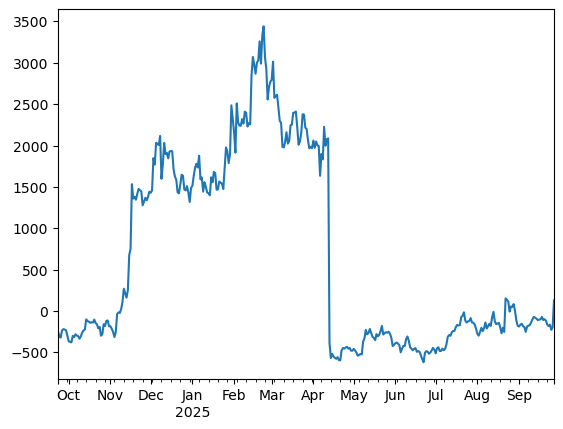

In [44]:
pnl_history['Total'].plot()

In [45]:
daily_pnl=pnl_history['Total']-pnl_history['Total'].shift(1)
daily_pnl[-31:]

2025-08-28     34.510654
2025-08-29    -80.680751
2025-08-30   -116.557176
2025-08-31    -64.917376
2025-09-01     -9.128634
2025-09-02     21.807289
2025-09-03     11.513615
2025-09-04    -30.406007
2025-09-05     -7.870188
2025-09-06    -59.574293
2025-09-07     64.103747
2025-09-08     10.429624
2025-09-09      7.514311
2025-09-10     32.069894
2025-09-11     38.330067
2025-09-12     28.157845
2025-09-13     -9.210608
2025-09-14    -12.518451
2025-09-15    -17.024334
2025-09-16      7.182172
2025-09-17      1.849051
2025-09-18     29.806058
2025-09-19    -37.805603
2025-09-20     10.375811
2025-09-21    -18.452314
2025-09-22    -45.323121
2025-09-23    -20.406501
2025-09-24     17.724228
2025-09-25    -61.920400
2025-09-26     29.559911
2025-09-27    326.259463
Name: Total, dtype: float64

In [46]:
days=0
pnl_timeframe=daily_pnl[-days:]
MtM=Binance.get_inventory().loc['Total']['Price in USDT']

var_amount=np.nanpercentile(pnl_timeframe,1)
var_pct=var_amount/MtM
cvar_amount=pnl_timeframe[pnl_timeframe<var_amount].mean()
cvar_pct=cvar_amount/MtM
var_amount,cvar_amount

(-367.8233255710326, -950.5160328166937)

In [47]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [48]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [49]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [50]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change(fill_method=None))


LDUMAUSDT not retrieved
Total not retrieved


In [51]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [52]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [ ]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

In [349]:
variance_decomposition=variance_decomposition_ex_post(quantities.fillna(0).loc['2025-09':],price_pnl.loc['2025-09':])
variance_decomposition_pct=variance_decomposition.copy()
total_var=variance_decomposition['Variance'].sum()
for col in variance_decomposition_pct.columns:
    variance_decomposition_pct[col]=variance_decomposition[col]/total_var

In [351]:
variance_decomposition_pct.round(4)

,Variance,Correlation,Idiosyncratic
BNBUSDT,0.0000,0.0000,0.0000
BTCUSDT,0.2680,0.0975,0.1706
ETHUSDT,0.0001,0.0001,0.0000
OMUSDT,0.0540,0.0344,0.0196
PEPEUSDT,0.0000,0.0000,0.0000
SOLUSDT,0.0001,0.0001,0.0000
TRXUSDT,0.6778,0.0942,0.5836
USDCUSDT,-0.0000,-0.0000,0.0000
BBUSDT,0.0000,0.0000,0.0000
JASMYUSDT,0.0000,0.0000,0.0000


In [56]:

# ptf=(quantities.fillna(0)*price_pnl).dropna()

# weights_ptf = ptf.div(ptf.sum(axis=1), axis=0).loc[ptf.index].to_numpy()

# r = price_pnl.pct_change().fillna(0).loc[ptf.index].to_numpy()
# T = r.shape[0]
# n = r.shape[1]

# r_mean = r.mean(axis=0)
# r_tilde = r - r_mean
# rp_tilde = (weights_ptf * r_tilde).sum(axis=1)

# C_mat = np.zeros((n, n))
# for t in range(T):
#     u = weights_ptf[t] * r_tilde[t]
#     C_mat += np.outer(u, u)

# C_mat /= (T - 1)

# diag_vec = np.diag(C_mat)
# offdiag = C_mat - np.diag(diag_vec)
# idiosyncratic = diag_vec
# correlation = 0.5 * offdiag.sum(axis=1)
# allocated = idiosyncratic + correlation

# results = pd.DataFrame({
#      "Variance": allocated,
#     "Correlation": correlation,
#    "Idiosyncratic": idiosyncratic
# }, index=price_pnl.columns)

# (results/results.sum(axis=0)).round(4)

In [57]:
variance_decomposition_ex_post(quantities.fillna(0),price_pnl)

,Variance,Correlation,Idiosyncratic
BNBUSDT,2.574367e-07,2.544482e-07,2.988449e-09
BTCUSDT,1.013329e-04,5.277539e-05,4.855753e-05
ETHUSDT,3.453742e-05,2.487285e-05,9.664574e-06
OMUSDT,1.025276e-03,6.556973e-05,9.597064e-04
PEPEUSDT,6.412999e-13,6.412999e-13,7.481448e-21
SOLUSDT,6.858327e-05,4.545676e-05,2.312651e-05
TRXUSDT,2.864874e-05,1.341205e-05,1.523668e-05
USDCUSDT,-2.334280e-13,-2.334289e-13,8.462210e-19
BBUSDT,5.466888e-06,5.066485e-06,4.004036e-07
JASMYUSDT,9.875659e-05,4.592319e-05,5.283340e-05


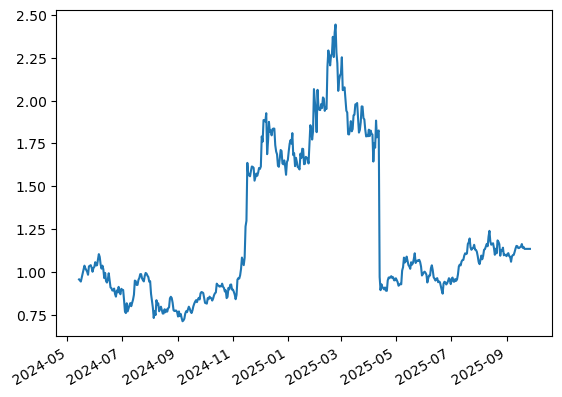

In [58]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()
plt.show()

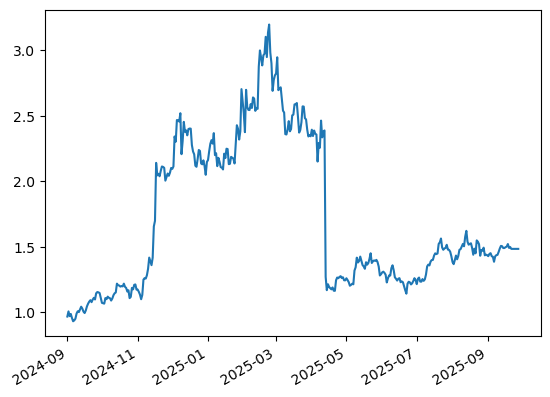

In [59]:
(1+historical_ptf['Historical Portfolio'].loc['2024-09':]).cumprod().plot()
plt.show()

## Ex ante data

In [61]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [64]:
days=120
historical_risk=RiskAnalysis(returns_to_use.iloc[-days:])
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[-days:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [65]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0]#,np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]
gold=np.where(returns_to_use.columns=='PAXGUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [68]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash]-0.00},
                                                                           {'type': 'eq', 'fun': lambda weights: 0.00-weights[gold]}])#,
                                                                              
                                                                              #{'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
BNBUSDT,0.6709
TRXUSDT,0.3291
WBETHUSDT,0.0000


In [69]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.0},
                                                                          {'type': 'ineq', 'fun': lambda weights: 0.0-weights[gold]},
                                                                          {'type': 'ineq', 'fun': lambda weights: 0.0-weights[cash]}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']
inventory

,Optimal Weights
BNBUSDT,0.671048
TRXUSDT,0.328953


In [70]:
tickers_frontier=holding_tickers.copy()
tickers_frontier.extend(list(inventory.index))

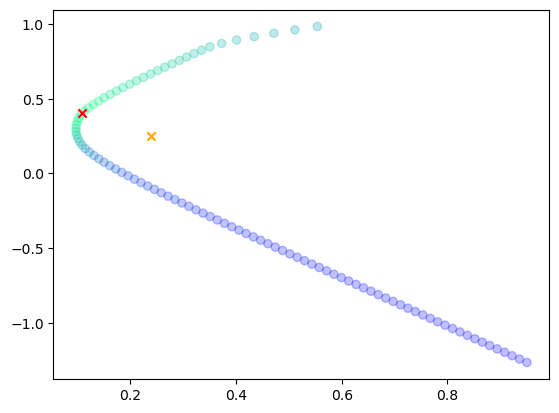

In [71]:
returns_frontier=returns_to_use[tickers_frontier].copy().iloc[-days:]
frontier_analysis=RiskAnalysis(returns_frontier)
current_weights_frontier=np.zeros(returns_frontier.shape[1])
current_weights_frontier[:current_weights.shape[0]]=current_weights
frontier_opt_weights=frontier_analysis.optimize(objective='sharpe_ratio')
X,Y,Z,C=frontier_analysis.efficient_frontier()
opt_res=frontier_analysis.performance(frontier_opt_weights),frontier_analysis.variance(frontier_opt_weights)
current_res=frontier_analysis.performance(current_weights_frontier),frontier_analysis.variance(current_weights_frontier)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()

In [72]:
dico={returns_frontier.columns[i]:frontier_opt_weights[i].round(4) for i in range(len(returns_frontier.columns))}
dico=pd.DataFrame(dico.values(),index=dico.keys(),columns=['Optimal Weights'])

In [73]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,dico],axis=1)
historical_comparison=historical_comparison.fillna(0)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison=historical_comparison.round(7)
historical_comparison.round(4)

,Price in USDT,Weights,Optimal Weights,Spread
TRXUSDT,1103.0334,0.5282,0.0608,0.4674
BTCUSDT,905.7015,0.4337,0.0000,0.4337
OMUSDT,79.0937,0.0379,0.0000,0.0379
ETHUSDT,0.1469,0.0001,0.0000,0.0001
SOLUSDT,0.0909,0.0000,0.0000,0.0000
BNBUSDT,0.0633,0.0000,0.0857,-0.0857
USDCUSDT,0.0333,0.0000,0.0000,0.0000
PEPEUSDT,0.0000,0.0000,0.0000,0.0000
PAXGUSDT,0.0000,0.0000,0.7071,-0.7071


### Current results

In [75]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

gold_current=np.where(ex_ante_perf_to_use.columns=='PAXGUSDT')[0][0]

In [76]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: 0.00-weights[gold_current]}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
BNBUSDT,0.671408
TRXUSDT,0.328592


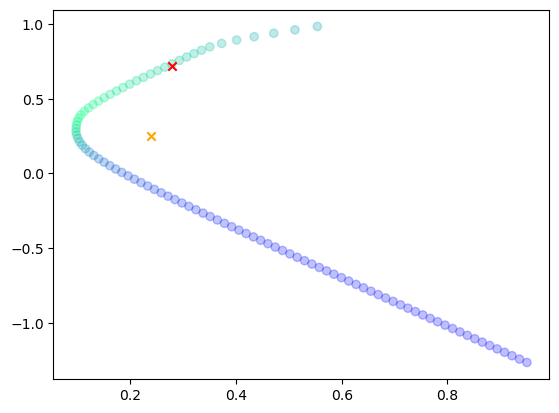

In [77]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()


In [78]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison=current_holding_comparison.round(7)
current_holding_comparison.round(4)

,Price in USDT,Weights,Optimal Weights,Spread
TRXUSDT,1103.0334,0.5282,0.3286,0.1996
BTCUSDT,905.7015,0.4337,0.0000,0.4337
OMUSDT,79.0937,0.0379,0.0000,0.0379
ETHUSDT,0.1469,0.0001,0.0000,0.0001
SOLUSDT,0.0909,0.0000,0.0000,0.0000
BNBUSDT,0.0633,0.0000,0.6714,-0.6714
USDCUSDT,0.0333,0.0000,0.0000,0.0000
PEPEUSDT,0.0000,0.0000,0.0000,0.0000


# Risk Reward Analysis

In [80]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [81]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf
portfolio_perf['Model']=performance_model_pct['Fund']

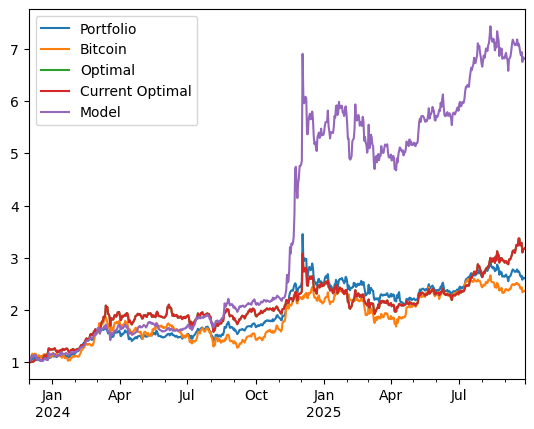

In [82]:
days=0
(1+portfolio_perf.iloc[-days:]).cumprod().plot()
plt.show()

In [83]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

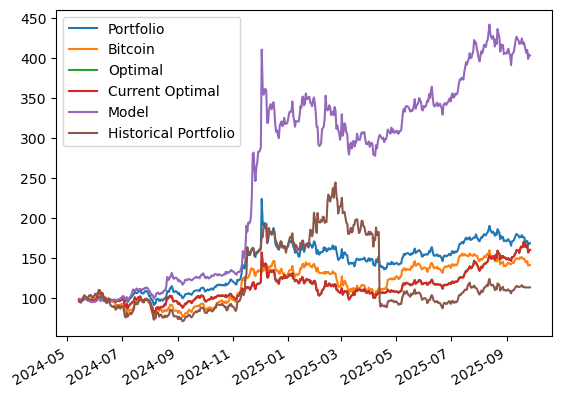

In [84]:
days=0
((1+current_perf.iloc[-days:]).cumprod()*100).plot()
plt.show()


<Axes: >

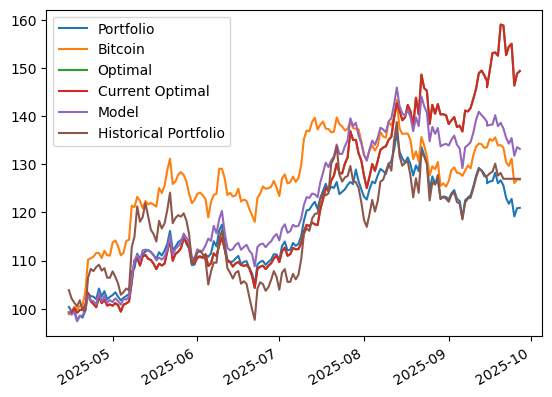

In [85]:
((1+current_perf.loc['2025-04-15':]).cumprod()*100).plot()

<Axes: >

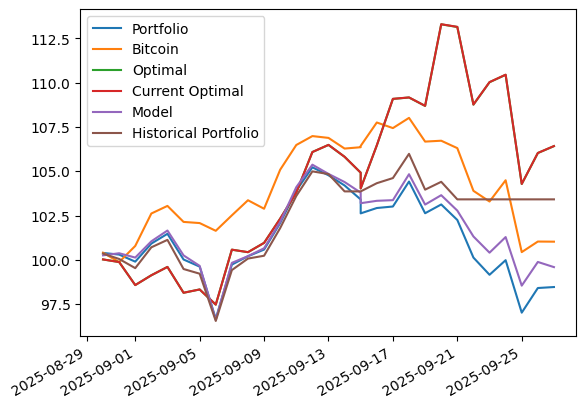

In [86]:
((1+current_perf.loc['2025-08-30':]).cumprod()*100).plot()

In [87]:
((1+current_perf.loc['2025-08-30':]).cumprod()*100)

,Portfolio,Bitcoin,Optimal,Current Optimal,Model,Historical Portfolio
2025-08-30,100.391876,100.404183,100.025204,100.025138,100.256523,100.353789
2025-08-31,100.299979,99.876884,99.879174,99.878714,100.375068,100.051951
2025-09-01,99.900927,100.787165,98.578707,98.578140,100.131022,99.535062
2025-09-02,100.920585,102.618109,99.132524,99.132126,101.048870,100.710311
2025-09-03,101.472401,103.046817,99.603528,99.602988,101.656804,101.129679
2025-09-04,100.021859,102.143595,98.145162,98.144799,100.253501,99.485482
2025-09-05,99.620262,102.078191,98.331437,98.331697,99.663249,99.220782
2025-09-06,96.676020,101.641846,97.474205,97.476752,96.614945,96.554921
2025-09-07,99.733826,102.513832,100.576006,100.577588,99.832474,99.424509
2025-09-08,100.206065,103.366171,100.434744,100.436232,100.211609,100.075140


## Volatilities

In [89]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.279237
 dtype: float64,
 0.27923742928108464)

In [90]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.239806
 dtype: float64,
 0.23980638732800763)

In [91]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.400691
Bitcoin            0.399359
Optimal            0.401353
Current Optimal    0.401345
Model              0.486524
dtype: float64

In [92]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.19607948687404403

In [93]:
days=30
current_perf['Historical Portfolio'].iloc[-days:].mean()*252/(current_perf['Historical Portfolio'].iloc[-days:].std()*np.sqrt(252))

1.6853383815992864

<Axes: >

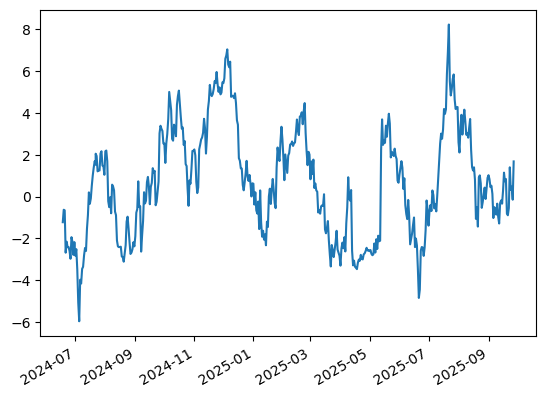

In [94]:
window=30
rolling_sharpe_ratio=current_perf['Historical Portfolio'].rolling(window).mean()*252/(current_perf['Historical Portfolio'].rolling(window).std()*np.sqrt(252))
rolling_sharpe_ratio.plot()

In [95]:
current_risk.performance(current_weights)/current_risk.variance(current_weights)

1.0547524292181214

## Risk Contribution

In [97]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis.round(4)

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,29.9620,0.7783,0.6672,0.1111
TRXUSDT,7.7493,0.2217,0.1106,0.1111
Portfolio,37.7113,1.0000,0.7778,0.2222


In [98]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,29.978096,0.778705,0.667723,0.110981
TRXUSDT,7.740780,0.221295,0.110314,0.110981
Portfolio,37.718875,1.000000,0.778037,0.221963


In [99]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
TRXUSDT,12.485432,0.549661,0.389265,0.160396
BTCUSDT,1.650660,0.366395,0.194883,0.171513
OMUSDT,-2.207561,0.083943,0.025135,0.058808
Portfolio,11.928532,1.000000,0.609283,0.390717


# Value At Risk

## Historical

### Optimal Weights

In [103]:
var,cvar=historical_risk.historical_var(opt_weights,Q=1)
(var,cvar)

(-0.04585763785977014, -0.05166754317715093)

### Current Weights

In [105]:
var,cvar=current_risk.historical_var(current_weights,Q=1)
(var,cvar)

(-0.032910667496941104, -0.03962581921103338)

In [106]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.01
row=round(historical_var.shape[0]*centile)

In [107]:
var=historical_var.iloc[row]
var

TRXUSDT     -0.024457
BTCUSDT     -0.006401
OMUSDT      -0.002727
ETHUSDT     -0.000000
SOLUSDT     -0.000000
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
PAXGUSDT     0.000000
Portfolio   -0.033585
Name: 2025-06-11 00:00:00, dtype: float64

In [108]:
cvar=historical_var.iloc[:row+1].mean()
cvar

TRXUSDT     -0.027083
BTCUSDT     -0.009704
OMUSDT      -0.002840
ETHUSDT      0.000000
SOLUSDT      0.000000
BNBUSDT      0.000000
PEPEUSDT     0.000000
PAXGUSDT     0.000000
Portfolio   -0.039626
dtype: float64

## Parametric

### Optimal Weights

In [111]:
var,cvar=historical_risk.parametric_var(opt_weights,Q=0.99)

(var,cvar)

(-0.0409211677885235, -0.05068354319170276)

### Current Weights

In [113]:
var,cvar=current_risk.parametric_var(current_weights,Q=0.99)

(var,cvar)

(-0.03514270073991758, -0.04352653374970959)

## Multivariate

### Optimal Weights

In [116]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.03806792950147557, -0.04351076560896441)

### Current Weights

In [118]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.03326603098763341, -0.039048606463907544)

In [119]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.01)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.01)]

    scenario_multivariate[i]=results.to_dict()

scenario=pd.DataFrame(scenario_multivariate).T
mean_scenario_multivariate=scenario.mean()
mean_scenario_multivariate

TRXUSDT     -0.017893
BTCUSDT     -0.013267
OMUSDT      -0.003119
Portfolio   -0.034280
dtype: float64

In [120]:
index_cvar=scenario['Portfolio']<mean_scenario_multivariate['Portfolio']
cvar_multivariate=scenario.loc[index_cvar].mean()
cvar_multivariate

TRXUSDT     -0.018371
BTCUSDT     -0.013817
OMUSDT      -0.002651
Portfolio   -0.034839
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [124]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.037919633313536816, -0.044101007260477304)

### Current Weights

In [126]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.03299165616047202, -0.03780458507591684)

In [127]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.01)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.01)]
    
    scenario_gaussian[i]=results

scenario=pd.DataFrame(scenario_gaussian).T
mean_scenario_gaussian=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gaussian['Portfolio']
cvar_gaussian=scenario.loc[index_cvar].mean()

## Student Copula

### Optimal Weights

In [130]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.038021586553807135, -0.044725111767293685)

### Current Weights

In [132]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.0362352992753032, -0.0415694442035355)

In [133]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.01)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.01)]
    
    scenario_t_copula[i]=results
    
scenario=pd.DataFrame(scenario_t_copula).T
mean_scenario_student=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_student['Portfolio']
cvar_student=scenario.loc[index_cvar].mean()

## Gumbel Copula

### Optimal Weights

In [136]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.08680760026719646, -0.1068225609680891)

### Current Weights

In [138]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.06383519941334828, -0.07838745599247114)

In [139]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    

scenario=pd.DataFrame(scenario_gumbel_copula).T
mean_scenario_gumbel=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gumbel['Portfolio']
cvar_gumbel=scenario.loc[index_cvar].mean()

## Monte Carlo

### Optimal

In [142]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [143]:
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.04119580392254228, -0.04741020436156073)

### Current Weights

In [145]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.0362837753170466, -0.0413107887528987)

In [146]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results

scenario=pd.DataFrame(scenario_monte_carlo).T
mean_scenario_monte_carlo=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_monte_carlo['Portfolio']
cvar_monte_carlo=scenario.loc[index_cvar].mean()

In [147]:
summary_var=pd.concat([mean_scenario_gumbel,mean_scenario_gaussian,mean_scenario_monte_carlo,mean_scenario_multivariate,mean_scenario_student],axis=1)
summary_var.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_var

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
TRXUSDT,-0.026067,-0.018226,-0.013894,-0.017893,-0.019349
BTCUSDT,-0.012932,-0.012847,-0.008977,-0.013267,-0.013179
OMUSDT,-0.001909,-0.003080,-0.002147,-0.003119,-0.003017
Portfolio,-0.040909,-0.034153,-0.025018,-0.034280,-0.035545


In [148]:
summary_cvar=pd.concat([cvar_gumbel,cvar_gaussian,cvar_monte_carlo,cvar_multivariate,cvar_student],axis=1)
summary_cvar.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_cvar

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
TRXUSDT,-0.026311,-0.018251,-0.014685,-0.018371,-0.019657
BTCUSDT,-0.013814,-0.013041,-0.008775,-0.013817,-0.013402
OMUSDT,-0.001458,-0.003223,-0.001807,-0.002651,-0.002979
Portfolio,-0.041582,-0.034514,-0.025267,-0.034839,-0.036038


## VaR Violation

In [150]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.023548,-0.053669,-0.047304,-0.014865
2024-01-15,-0.023548,-0.054772,-0.046201,0.031504
2024-01-16,-0.023548,-0.054025,-0.046764,-0.006640
2024-01-17,-0.023548,-0.054580,-0.048593,-0.011521
2024-01-18,-0.023548,-0.053631,-0.047422,0.007003
...,...,...,...,...
2025-09-24,-0.031836,-0.038810,-0.034071,0.003803
2025-09-25,-0.050848,-0.044957,-0.042405,-0.055803
2025-09-26,-0.050848,-0.044958,-0.040993,0.016771
2025-09-27,-0.050848,-0.044663,-0.043698,0.003665


In [151]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2023-12-15,-0.047061,-0.047914,-0.044044,-0.036553
2023-12-16,-0.047061,-0.047992,-0.045430,0.010582
2023-12-17,-0.047061,-0.048627,-0.047341,-0.013541
2023-12-18,-0.047061,-0.048719,-0.047325,0.007048
2023-12-19,-0.047061,-0.046200,-0.046844,-0.004539
...,...,...,...,...
2025-09-24,-0.020240,-0.027715,-0.027873,0.008312
2025-09-25,-0.028382,-0.031247,-0.033183,-0.029625
2025-09-26,-0.028382,-0.030404,-0.033626,0.014336
2025-09-27,-0.028382,-0.028810,-0.032070,0.000562


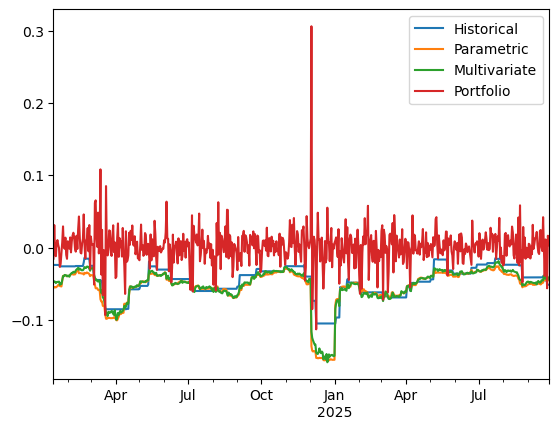

In [152]:
var_data.plot()
plt.show()

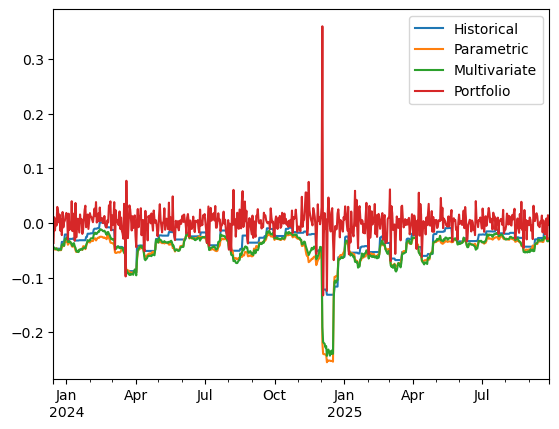

In [153]:
current_var_data.plot()
plt.show()


In [154]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.036859,0.011218,0.012821
Kupiec Stat,2.48641,28.451635,25.520719
P-value,0.114833,0.0,0.0


In [155]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.071865,0.009174,0.010703
Kupiec Stat,5.832304,34.183937,30.868206
P-value,0.015735,0.0,0.0


# Principal Component Analysis

## Historical PCA

In [158]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.86176342, 0.04297507, 0.03427128, 0.0324295 , 0.02856073])

In [159]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT     0.021345
ADAUSDT      0.019449
ALGOUSDT     0.022977
APTUSDT      0.020147
ARBUSDT      0.029432
ATOMUSDT     0.017852
AVAXUSDT     0.021099
BCHUSDT      0.010671
BNBUSDT      0.009774
BONKUSDT     0.027560
BTCUSDT      0.007480
CAKEUSDT     0.017157
CRVUSDT      0.024166
DOGEUSDT     0.023826
DOTUSDT      0.020090
ETCUSDT      0.019417
ETHUSDT      0.018440
FDUSDUSDT    0.000096
FETUSDT      0.021638
FILUSDT      0.020514
FLOKIUSDT    0.028742
GRTUSDT      0.022110
HBARUSDT     0.021986
ICPUSDT      0.020144
IMXUSDT      0.028317
INJUSDT      0.027105
LDOUSDT      0.027629
LINKUSDT     0.023165
LTCUSDT      0.015059
NEARUSDT     0.024089
NEXOUSDT     0.007682
OMUSDT       0.023797
OPUSDT       0.027569
PAXGUSDT    -0.000169
PEPEUSDT     0.025837
QNTUSDT      0.015750
RAYUSDT      0.024452
SEIUSDT      0.025703
SHIBUSDT     0.018470
SOLUSDT      0.019752
STXUSDT      0.022246
SUIUSDT      0.023846
TRXUSDT      0.005516
UNIUSDT      0.023985
USDCUSDT    -0.000015
VETUSDT   

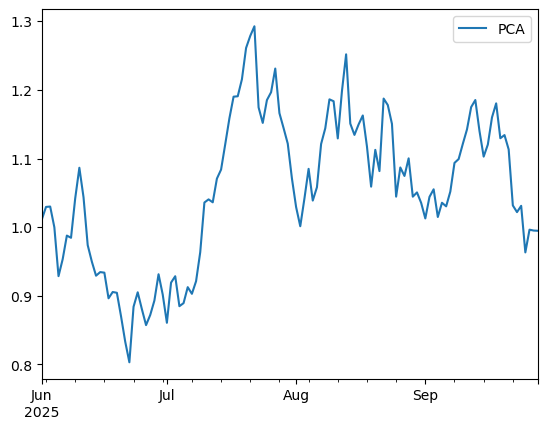

In [160]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()
plt.show()

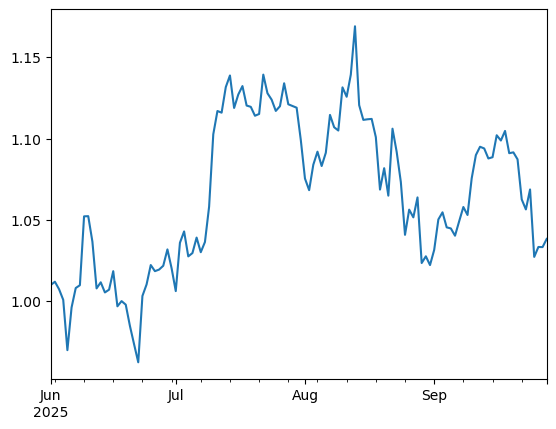

In [161]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [162]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances[:20]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
DOTUSDT      0.124066
SHIBUSDT     0.124347
FILUSDT      0.135105
VETUSDT      0.135910
ATOMUSDT     0.141115
GRTUSDT      0.149065
ICPUSDT      0.155030
NEARUSDT     0.163573
ADAUSDT      0.181723
PEPEUSDT     0.182592
WBETHUSDT    0.185478
ETHUSDT      0.185580
APTUSDT      0.190886
STXUSDT      0.192966
DOGEUSDT     0.195764
FETUSDT      0.196842
ETCUSDT      0.197732
SOLUSDT      0.199368
INJUSDT      0.214467
dtype: float64

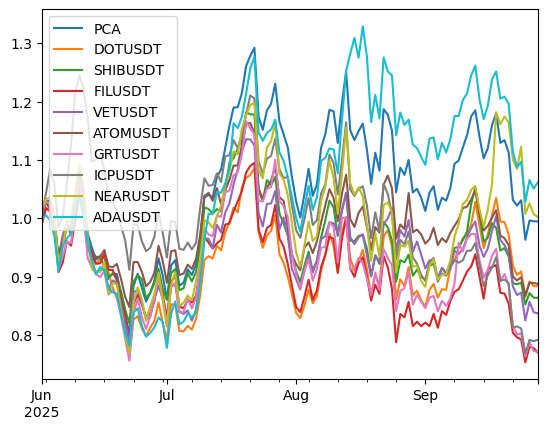

In [163]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()

<Axes: >

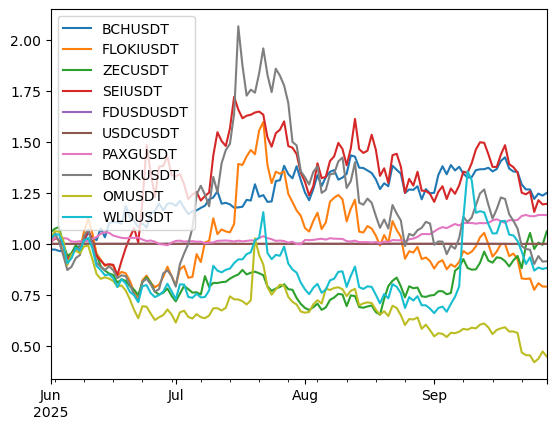

In [164]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [166]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.75184126, 0.16382536, 0.03750971, 0.02512231, 0.02170136])

In [167]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

TRXUSDT     0.042344
BTCUSDT     0.060478
OMUSDT      0.268186
ETHUSDT     0.157653
SOLUSDT     0.166831
BNBUSDT     0.085874
PEPEUSDT    0.220572
PAXGUSDT   -0.001937
Name: PC1, dtype: float64

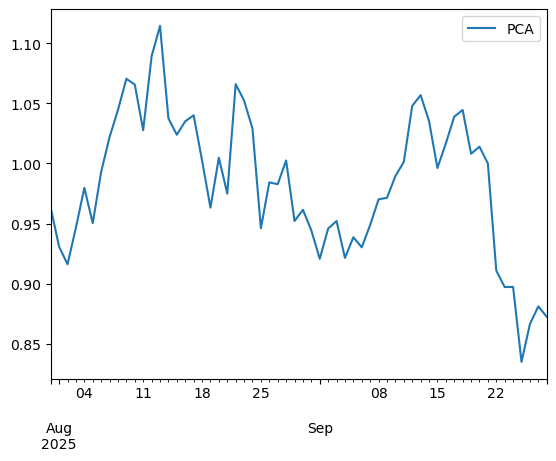

In [168]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA.iloc[-60:]).cumprod().plot()
plt.show()

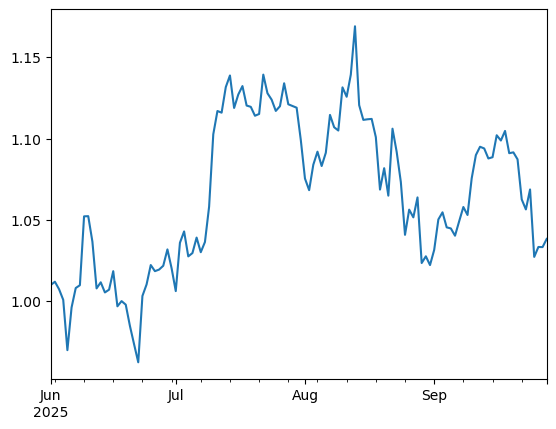

In [169]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [170]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA         0.000000
ETHUSDT     0.201286
PEPEUSDT    0.214768
SOLUSDT     0.223872
BNBUSDT     0.260812
BTCUSDT     0.287070
TRXUSDT     0.349116
OMUSDT      0.374658
PAXGUSDT    0.403390
dtype: float64

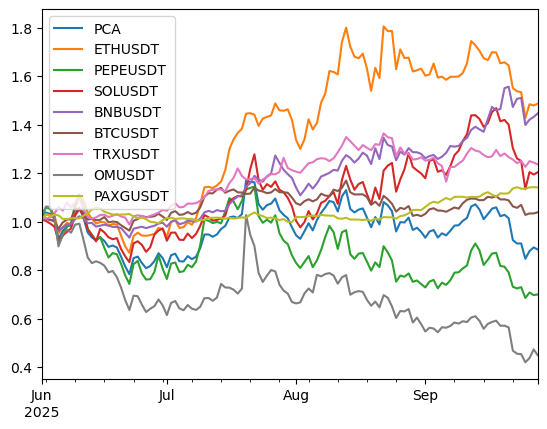

In [171]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()


## Sensitivity Analysis

In [173]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT    1.925045
SOLUSDT     1.307291
ETHUSDT     1.113301
OMUSDT      1.024537
BTCUSDT     1.000000
BNBUSDT     0.677823
TRXUSDT     0.343218
PAXGUSDT    0.028558
Name: BTCUSDT, dtype: float64

In [174]:
days=30
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

SOLUSDT     2.354193
OMUSDT      2.352322
PEPEUSDT    2.054300
ETHUSDT     1.440956
BNBUSDT     1.298511
BTCUSDT     1.000000
TRXUSDT     0.694471
PAXGUSDT   -0.053944
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [176]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [177]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
PEPEUSDT,0.374178
BTCUSDT,0.300012
SOLUSDT,0.233369
OMUSDT,0.102862
BNBUSDT,0.056380
TRXUSDT,-0.008595
ETHUSDT,-0.011177
PAXGUSDT,-0.195034


### Regression to PCA

In [179]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-30:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

1.4071885987512118

In [180]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

PCA         1.000000
ETHUSDT     0.902615
BNBUSDT     0.812054
BTCUSDT     0.751325
SOLUSDT     0.616719
PEPEUSDT    0.317125
TRXUSDT     0.269613
OMUSDT      0.140465
PAXGUSDT   -0.143345
dtype: float64

In [181]:
reg=ex_ante_perf.copy().dropna().iloc[-30:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT     1.920206
PCA         1.000000
ETHUSDT     0.995825
TRXUSDT     0.833890
BNBUSDT     0.831469
SOLUSDT     0.762763
PEPEUSDT    0.756852
OMUSDT      0.504417
PAXGUSDT   -1.186059
dtype: float64

### Correlation Matrix

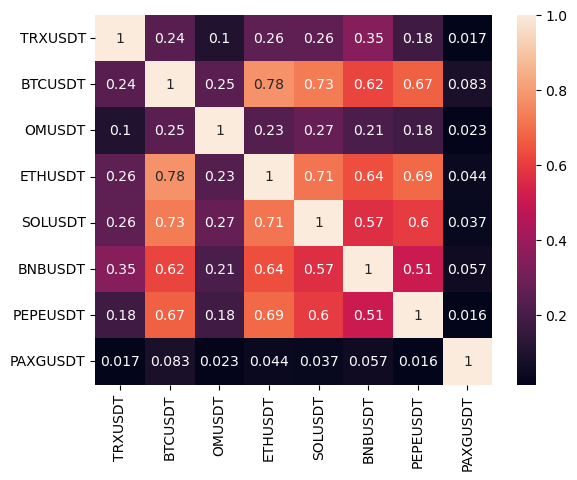

In [183]:
sns.heatmap(ex_ante_perf.corr(),annot=True)
plt.show()


<Axes: >

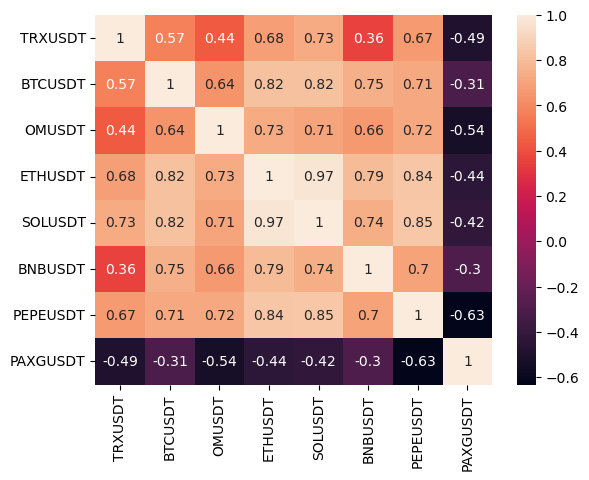

In [184]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

In [185]:
gold=get_close(['SPY','GOLD.PA'],start=start_date.strftime("%Y-%m-%d"),end=enddate.strftime("%Y-%m-%d")).dropna()
gold.index=pd.to_datetime(gold.index)
pct_change=gold.pct_change().sort_index()

In [186]:
correlation=pct_change['GOLD.PA'].rolling(30).corr(pct_change['SPY']).dropna()
beta=(pct_change['GOLD.PA'].rolling(30).cov(pct_change['SPY']).dropna()/pct_change['SPY'].rolling(30).var().dropna())

<Axes: >

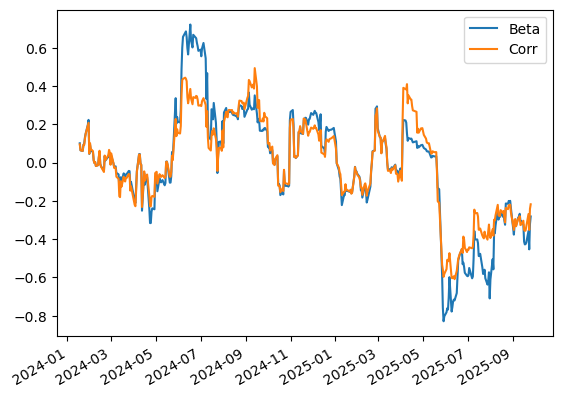

In [187]:
info=pd.DataFrame()
info['Beta']=beta
info['Corr']=correlation

info.plot()

## Sliding window optimization

In [189]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,TRXUSDT,BTCUSDT,OMUSDT,ETHUSDT,SOLUSDT,BNBUSDT,PEPEUSDT,PAXGUSDT
2023-12-14,0.000000,0.107613,0.104338,0.000000,0.000000,0.522522,0.000000,0.265527
2023-12-28,0.000000,0.000000,0.000000,0.000000,0.331762,0.668238,0.000000,0.000000
2024-01-11,0.000000,0.000000,0.560261,0.439739,0.000000,0.000000,0.000000,0.000000
2024-01-25,0.379492,0.000000,0.104622,0.000000,0.000000,0.000000,0.000000,0.515886
2024-02-08,0.066364,0.000000,0.047113,0.191144,0.041760,0.000000,0.000000,0.653620
2024-02-22,0.705974,0.000000,0.000000,0.164223,0.000000,0.129803,0.000000,0.000000
2024-03-07,0.000000,0.000000,0.000000,0.020832,0.156080,0.000000,0.046602,0.776486
2024-03-21,0.000000,0.000000,0.462471,0.000000,0.000000,0.471815,0.065714,0.000000
2024-04-04,0.000000,0.000920,0.019296,0.000000,0.000000,0.113904,0.000000,0.865879
2024-04-18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [190]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='PAXGUSDT')[0][0]

In [191]:
for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit[0]]-0.0},
                                                                    {'type': 'eq', 'fun': lambda weights: weights[limit[1]]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ATOMUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,BONKUSDT,...,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT,ZECUSDT
2025-02-20,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2025-03-22,0.000000,0.421219,0.004738,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2025-04-21,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.460152,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2025-05-21,0.227946,0.000000,0.024705,0.0,0.0,0.0,0.000000,0.000000,0.098207,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.299761
2025-06-20,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2025-07-20,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.239238,0.000000,0.141591,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.081827,0.287923,0.000000
2025-08-19,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.192998,0.000000,...,0.782996,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2025-09-18,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.537574,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.058483,0.000000,0.000000,0.352685
2025-09-28,0.000000,0.019496,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.980504


In [192]:
rolling_optimization.iloc[-2].sort_values(ascending=False)[:6]

AVAXUSDT    0.537574
ZECUSDT     0.352685
WLDUSDT     0.058483
SOLUSDT     0.034041
IMXUSDT     0.017217
SHIBUSDT    0.000000
Name: 2025-09-18 00:00:00, dtype: float64

In [193]:
git.create_or_replace_notebook("Prod.ipynb")

File 'Prod.ipynb' exists. Replacing the file...
✅ File 'Prod.ipynb' successfully pushed/updated to GitHub!
